<a href="https://colab.research.google.com/github/rsbaye/Data-Science-Projects/blob/main/Markov_with_discounting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [15]:
# General Setup
cycle_length = 1  # cycle length in years
n_age_init = 25  # initial age
n_age_max = 100  # maximum age
n_cycles = int((n_age_max - n_age_init) / cycle_length)  # number of cycles

state_names = ["H", "S1", "S2", "D"]  # Health states
n_states = len(state_names)  # number of health states

discount_rate_qalys = 0.03  # annual discount rate for QALYs
discount_rate_costs = 0.03  # annual discount rate for costs

strategy_names = ["Standard of care", "Strategy A", "Strategy B", "Strategy AB"]  # Strategy names


In [16]:
# Transition Rates and Probabilities
r_HD = 0.002  # annual mortality rate when Healthy
r_HS1 = 0.15  # annual rate of becoming Sick when Healthy
r_S1H = 0.5  # annual rate of becoming Healthy when Sick
r_S1S2 = 0.105  # annual rate of becoming Sicker when Sick

hr_S1 = 3  # hazard ratio of death in Sick vs Healthy
hr_S2 = 10  # hazard ratio of death in Sicker vs Healthy

p_HS1 = 1 - np.exp(-r_HS1 * cycle_length)
p_S1H = 1 - np.exp(-r_S1H * cycle_length)
p_S1S2 = 1 - np.exp(-r_S1S2 * cycle_length)


In [18]:

# Treatment B effectiveness
hr_S1S2_trtB = 0.6  # hazard ratio under treatment B
r_S1S2_trtB = r_S1S2 * hr_S1S2_trtB
p_S1S2_trtB = 1 - np.exp(-r_S1S2_trtB * cycle_length)


In [19]:
# State Costs and Utilities
c_H = 2000  # cost for Healthy
c_S1 = 4000  # cost for Sick
c_S2 = 15000  # cost for Sicker
c_D = 0  # cost for Dead

c_trtA = 12000  # cost for treatment A
c_trtB = 13000  # cost for treatment B

u_H = 1.0  # utility for Healthy
u_S1 = 0.75  # utility for Sick
u_S2 = 0.5  # utility for Sicker
u_D = 0.0  # utility for Dead

u_trtA = 0.95  # utility under treatment A


In [20]:
# Mortality Probabilities
r_S1D = r_HD * hr_S1  # death rate when Sick
r_S2D = r_HD * hr_S2  # death rate when Sicker

p_HD = 1 - np.exp(-r_HD * cycle_length)
p_S1D = 1 - np.exp(-r_S1D * cycle_length)
p_S2D = 1 - np.exp(-r_S2D * cycle_length)


In [21]:

# Initial State Vector
initial_state = np.array([1, 0, 0, 0])  # starting in Healthy state

# Transition Probability Matrices
P = np.zeros((n_states, n_states))
P[0, 0] = (1 - p_HD) * (1 - p_HS1)  # H to H
P[0, 1] = (1 - p_HD) * p_HS1  # H to S1
P[0, 3] = p_HD  # H to D

P[1, 0] = (1 - p_S1D) * p_S1H  # S1 to H
P[1, 1] = (1 - p_S1D) * (1 - p_S1H - p_S1S2)  # S1 to S1
P[1, 2] = (1 - p_S1D) * p_S1S2  # S1 to S2
P[1, 3] = p_S1D  # S1 to D

P[2, 2] = 1 - p_S2D  # S2 to S2
P[2, 3] = p_S2D  # S2 to D

P[3, 3] = 1  # D to D

# Transition matrix for Strategy B
P_strB = P.copy()
P_strB[1, 1] = (1 - p_S1D) * (1 - p_S1H - p_S1S2_trtB)
P_strB[1, 2] = (1 - p_S1D) * p_S1S2_trtB


In [22]:
# Initialize Markov Trace
markov_trace = np.zeros((n_cycles + 1, n_states))
markov_trace[0, :] = initial_state

# Run Markov Model
for t in range(1, n_cycles + 1):
    markov_trace[t, :] = markov_trace[t - 1, :].dot(P)

# Cost and Utility Vectors
costs = np.array([c_H, c_S1, c_S2, c_D]) * cycle_length
utilities = np.array([u_H, u_S1, u_S2, u_D]) * cycle_length

# Calculate Total Costs and QALYs
total_costs = markov_trace.dot(costs)
total_qalys = markov_trace.dot(utilities)

# Apply Discounting
discount_factors_costs = 1 / (1 + discount_rate_costs) ** np.arange(n_cycles + 1)
discount_factors_qalys = 1 / (1 + discount_rate_qalys) ** np.arange(n_cycles + 1)

discounted_costs = total_costs * discount_factors_costs
discounted_qalys = total_qalys * discount_factors_qalys

# Sum Total Costs and QALYs
sum_total_costs = np.sum(discounted_costs)
sum_total_qalys = np.sum(discounted_qalys)

print(f"Total discounted costs: {sum_total_costs}")
print(f"Total discounted QALYs: {sum_total_qalys}")


Total discounted costs: 153541.41293063213
Total discounted QALYs: 21.5544866105017


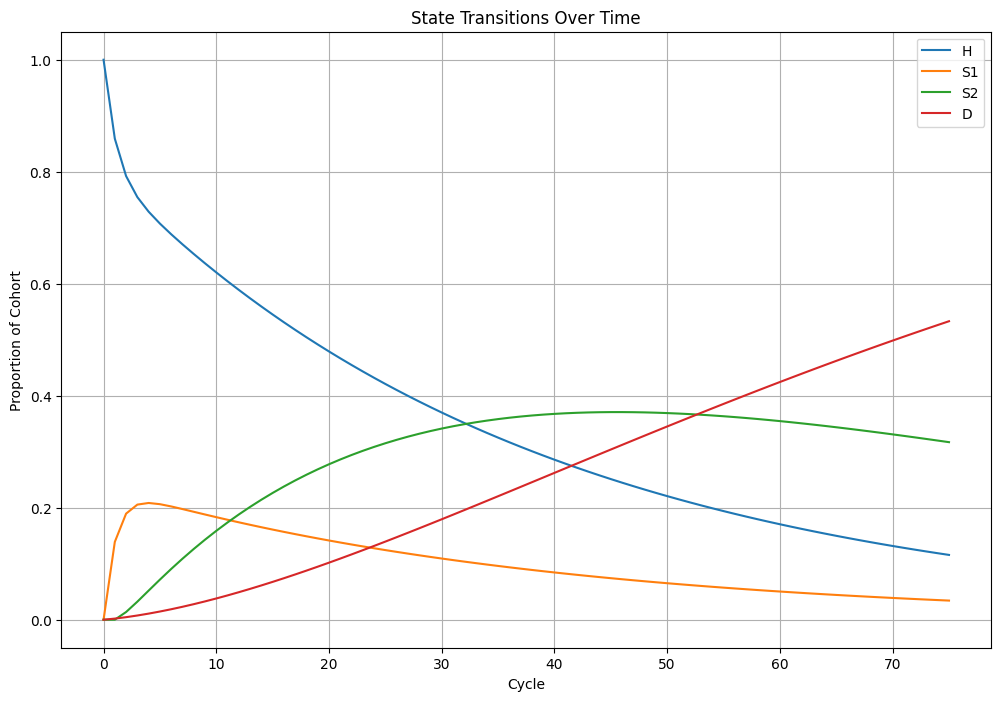

In [23]:



# Define the number of cycles
cycles = np.arange(n_cycles + 1)

# Plotting the Markov trace
plt.figure(figsize=(12, 8))
for i, state in enumerate(state_names):
    plt.plot(cycles, markov_trace[:, i], label=state)
plt.xlabel('Cycle')
plt.ylabel('Proportion of Cohort')
plt.title('State Transitions Over Time')
plt.legend()
plt.grid(True)
plt.show()




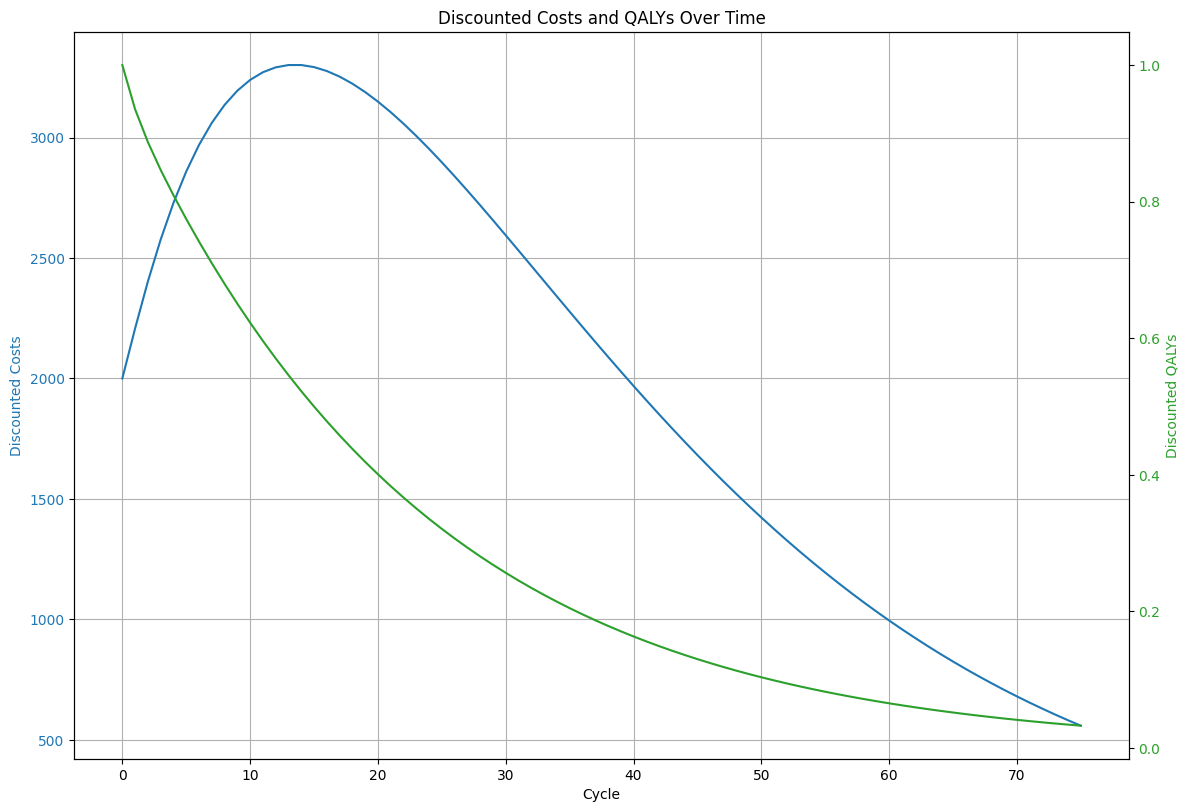

In [24]:
# Plotting discounted costs and QALYs
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Cycle')
ax1.set_ylabel('Discounted Costs', color=color)
ax1.plot(cycles, discounted_costs, color=color, label='Discounted Costs')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Discounted QALYs', color=color)
ax2.plot(cycles, discounted_qalys, color=color, label='Discounted QALYs')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Discounted Costs and QALYs Over Time')
plt.show()


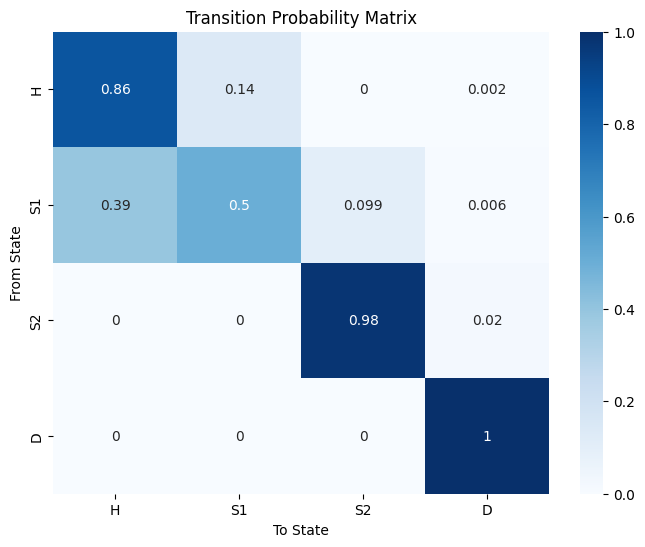

In [13]:


# Plotting the transition probability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(P, annot=True, cmap='Blues', xticklabels=state_names, yticklabels=state_names)
plt.xlabel('To State')
plt.ylabel('From State')
plt.title('Transition Probability Matrix')
plt.show()


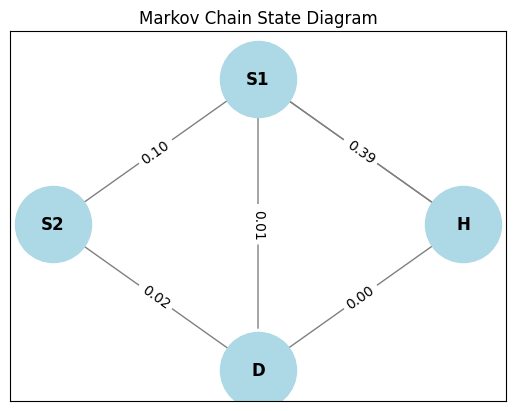

In [25]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for state in state_names:
    G.add_node(state)

# Add edges with transition probabilities as weights
for i, from_state in enumerate(state_names):
    for j, to_state in enumerate(state_names):
        if P[i, j] > 0:
            G.add_edge(from_state, to_state, weight=P[i, j])

# Define positions for a circular layout
pos = nx.circular_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# Draw the edges
edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray')

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels (transition probabilities)
edge_labels = {(from_state, to_state): f'{P[i, j]:.2f}'
               for i, from_state in enumerate(state_names)
               for j, to_state in enumerate(state_names) if P[i, j] > 0}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title('Markov Chain State Diagram')
plt.show()
